In [43]:
import os, sys
import json
import pandas as pd
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import gensim
from gensim import corpora
import seaborn as sns
import matplotlib.pyplot as plt

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Constructed Dataset

In [2]:
path = "data/"
industry = pd.read_csv(path + "corporate-abstracts.csv")
academia = pd.read_csv(path + 'facct-abstracts-labeled.csv')
industry = list(industry['abstract'])
facct_industry = list(academia[academia['industry'] == True]['abstract'])
facct_academia = list(academia[academia['industry'] == False]['abstract'])
industry.extend(facct_industry)
industry = list(set(industry))
academia = list(set(facct_academia))
full_dataset = industry + academia

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling

In [3]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

academia_clean = [clean(doc).split() for doc in academia]
industry_clean = [clean(doc).split() for doc in industry]
full_clean = [clean(doc).split() for doc in full_dataset]

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
academia_dict = corpora.Dictionary(academia_clean)
industry_dict = corpora.Dictionary(industry_clean)
full_dict = corpora.Dictionary(full_clean)
academia_term_matrix = [academia_dict.doc2bow(doc) for doc in academia_clean]
industry_term_matrix = [industry_dict.doc2bow(doc) for doc in industry_clean]
full_term_matrix = [full_dict.doc2bow(doc) for doc in full_clean]

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Word cloud

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


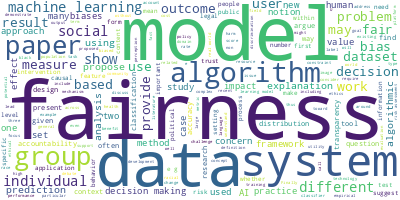

In [5]:
# Academia wordcloud
long_string = ','.join(list(academia))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


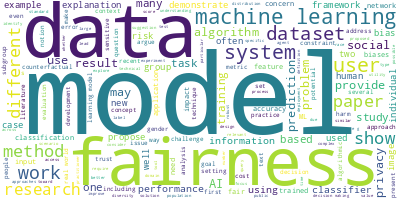

In [6]:
# Industry wordcloud
long_string = ','.join(list(industry))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


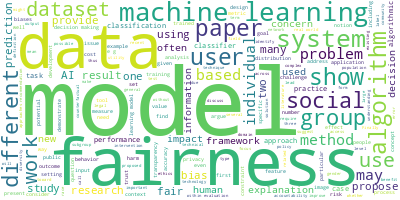

In [7]:
# Entire dataset wordcloud
long_string = ','.join(list(full_dataset))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

## LDA

In [8]:
# Academia
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(academia_term_matrix, num_topics=5, id2word=academia_dict, passes=50)
lda_display = gensimvis.prepare(ldamodel, academia_term_matrix, academia_dict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Industry
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(industry_term_matrix, num_topics=5, id2word=industry_dict, passes=50)
lda_display = gensimvis.prepare(ldamodel, industry_term_matrix, industry_dict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Full Dataset
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(industry_term_matrix, num_topics=5, id2word=industry_dict, passes=50)
lda_display = gensimvis.prepare(ldamodel, industry_term_matrix, industry_dict, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Binary Classification

In [15]:
x_academia = academia
y_academia = [0]*len(x_academia)
x_industry = industry
y_industry = [1]*len(x_industry)
X = x_academia + x_industry
y = y_academia + y_industry

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(64, 2660)

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(64, 2660)

In [29]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train_tf.toarray(), y_train)

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Evaluate
X_test_counts = count_vect.transform(X_test)
X_test_tf = tf_transformer.transform(X_test_counts)

predicted = clf.predict(X_test_tf.toarray())

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, predicted, average='macro')
print("Precision: ", precision)
print("Recall: ", recall)
print("Fscore: ", fscore)

Precision:  0.5770956165085875
Recall:  0.5715262500743207
Fscore:  0.5678231033168127


/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
# Look at this for interpretability
clf.theta_.shape

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2, 2660)

/Users/aishwaryamandyam/anaconda3/envs/534/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

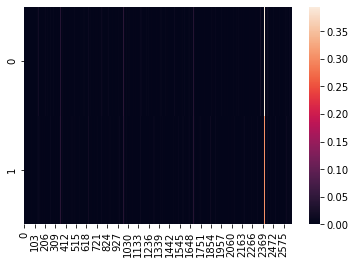

In [44]:
sns.heatmap(clf.theta_)